# Project: Electric Vehicle Charging Scheduling Problem (EVCS)
## First deliverable
## Prescriptive Analytics: Heuristics for Decision Making
### Wilmar Calderón - 201630701

The Electric Vehicle Charging Scheduling (EVCS) problems aims to determine the optimal sequence of charging $n$ vehicles in $m$ chargers. The EVCS can be formulated with multiple objectives as reducing cost or maximizing the charge, which are the most common objectives for the problem. This implementation describes a Mixed-Integer-Linear-Programming (MILP) formulation to obtain an exact solution for the EVCS.  

### **Mathematical Formulation of the Electric Vehicle Charging Scheduling (EVCS) Problem**

The **EV Charging Scheduling -EVCS-** can be mathematically formulated as follows:


#### **Parameters**

- $t$: Time Index  
- $t_m$: Charging station service time end  
- $e_t$: Electricity price at time $t$  
- $\lambda$: Penalty fee for not attending charge of an EV  
- $c$: Index for the chargers  
- $n_c$: Total number of chargers  
- $P_c$: Maximum power of each charger  
- $L$: Maximum capacity of the transformer of the station  
- $n$: Index for the EVs  
- $n_{EV}$: Total number of EVs  
- $t_n^a$: Time of arrival of the $n$-th EV  
- $t_n^d$: Time of departure of the $n$-th EV  
- $E_n^{\text{req}}$: Requested energy of the $n$-th EV  

#### **Sets**

- $T = \{0, 1, 2, \dots, t_m\}$: Time periods sampled between 0 and $t_m$  
- $C = \{0, 1, 2, \dots, n_c\}$: Chargers available at the station  
- $N = \{0, 1, 2, \dots, n_{EV}\}$: Set of EVs evaluated  

#### **Decision Variables**  

- $\xi_{n,c,t} \in \{0,1\} \quad \forall \: c \in C,\; n \in N,\; t \in T$: Binary variable indicating whether the $n$-th EV is at charger $c$ at time $t$  
- $P_{n,t} \ge 0$: The power supplied to the $n$-th vehicle at time $t$  
- $s_n \ge 0$: Unattended energy (slack) of the $n$-th EV  

#### **Objective Function**

$$
\min \sum_{n \in N} \sum_{t \in T}  e_{t} \cdot P_{n,t} + \lambda \sum_{n \in N} s_{n}
$$

#### **Restrictions**

$$
\sum_{n=1}^N \xi_{n,c,t} \le M \quad \forall \: c \in C,\: \forall \: t \in T
$$

$$
\sum_{n=1}^N P_{n,t} \le L \quad \forall \: t \in T
$$

$$
P_{n,t} \le \xi_{n,c,t} \cdot P_c \quad \forall \: n \in N,\: \forall \: c \in C,\: \forall \: t \in T
$$

$$
\sum_{t = t_n^a}^{t_n^d + y_n} P_{n,t} \le E_n^{req} \quad \forall \: n \in N
$$

$$
P_{n,t} = 0 \quad \forall \: n \in N,\: t \notin [t_n^a, t_n^d]
$$

## Implementation

In [ ]:
#Main libraries importation
import json
import pandas as pd
from typing import Dict, Tuple
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time

In [32]:
#JSON File reader
#Input: Filepath
#Output: dict(Pandas Dataframes with the loaded information), int(number of parking spots), int(transformer limit)
def load_json_to_dfs(file_path: str) -> Tuple[Dict[str, pd.DataFrame], int, int]:
    with open(file_path, 'r') as file:
        data = json.load(file)
    dfs = {} #Dictionary where the dataframes will be sotred
    # Extracts the information in the JSON file of the filepath entered as parameter
    parking_config = data.get('parking_config', {})  #info related to the chargers
    n_spot = parking_config['n_spots'] #number of parking spots
    transformer_limit =parking_config['transformer_limit'] #Transformer limit

    dfs['energy_prices'] = pd.DataFrame(data['energy_prices'], columns=['time', 'price']) #Energy price dataframe
    dfs['arrivals'] = pd.DataFrame(data['arrivals'], columns=['id', 'arrival_time', 'departure_time', 'required_energy']) #Extraction of details of the attended EV
    dfs['chargers'] = pd.DataFrame(parking_config['chargers'],columns=["charger_id","power"]) #Chargers Dataframe
    
    return dfs, n_spot, transformer_limit



In [ ]:
step=0.05 #Time spacing: Model parameter (value corresponds to fraction of an hour)

#Function that creates the Gurobi model and calculates the performance metrics of the scheduling
def EVCS(dfs, n_spot, transformer_limit,inst): 
    #Datasets
    energy_p=dfs["energy_prices"]
    arrivals=dfs["arrivals"]
    chargers=dfs["chargers"]
    #Parameters

    
    lambda_c=max(energy_p["price"])*10 #penalty: defined as 10 times the most expensive kWh.

    #Related to the time period analyzed
    T_max=max(arrivals["departure_time"]) #Detail of the last departure
    T=list(np.round(np.arange(0,T_max+step,step),2)) #List of the time periods analyzed

    #Related to the EV arrivals
    N=arrivals["id"].tolist()
    t_a = dict(zip(arrivals['id'], arrivals['arrival_time']))
    t_d = dict(zip(arrivals['id'], arrivals['departure_time']))
    e_req=dict(zip(arrivals['id'], arrivals['required_energy']))

    #Related to the chargers
    charger_power = chargers.set_index('charger_id')['power'].to_dict() #P_c list
    C = chargers['charger_id'].tolist()
    M=chargers.shape[0] #M=Number of chargers

    #Related to the energy price
    energy_price_dict = dict(zip(energy_p['time'], energy_p['price']))
    energy_prices_df = pd.DataFrame(list(energy_price_dict.items()), columns=["time", "price"]).sort_values("time")
    T_df = pd.DataFrame({"time": list(T)}).sort_values("time")
    T_df = pd.merge_asof(T_df, energy_prices_df, on="time", direction="backward")
    e_t = dict(zip(T_df["time"].round(2), T_df["price"]))

    #Model definition

    from gurobipy import Model, GRB, quicksum

    model = gp.Model("ev_charging")
    # Variables
    P = model.addVars(N, T, name="P", lb=0.0)
    xi = model.addVars(N, C, T, vtype=GRB.BINARY, name="xi")
    s = model.addVars(N, name="s", lb=0.0)  # Slack variable

    #objective Function
    model.setObjective(
        quicksum(P[n, t] * e_t[t] for n in N for t in T)+ quicksum(lambda_c * s[n] for n in N),
        GRB.MINIMIZE
    )

    #Restriction 1
    # Limit of the chargers
    for c in C:
        for t in T:
            model.addConstr(
                quicksum(xi[n, c, t] for n in N) <= M,
                name=f"charger_usage_limited_{c}_{t}"
            )

    #Restriction 2
    # Charging station transformer limit
    for t in T:
        model.addConstr(
            quicksum(P[n, t] for n in N) <= transformer_limit *step,
            name=f"transformer_limit_{t}"
        )

    #Restriction 3
    # Charger Capacity and activation
    for n in N:
        for c in C:
            for t in T:
                model.addConstr(
                    P[n, t] <= xi[n, c, t] * charger_power[c] *step,
                    name=f"charger_power_limit_{n}_{c}_{t}"
                )


    #Restriction 4
    # Charging of the EV must be larger or equal to the requirement of the EV. This will consider that the variable s_n is activated as a slack variable to model that all EV's have been reviewed.
    for n in N:
        model.addConstr(
            quicksum(P[n, t] for t in T if t_a[n] <= t <= t_d[n])+ s[n] >= e_req[n],
            name=f"energy_requirement_{n}"
        )

    # Restriction 5
    # Charging can only happen between the arrival and departure time.
    for t in T:
        for n in N:
            if not (t_a[n] <= t <= t_d[n]):
                model.addConstr(P[n, t] == 0, name=f"outside_time_{n}_{t}")

        


    # Optimization
    model.setParam('OutputFlag', 0)
    # model.setParam(GRB.Param.MIPGap, 0.0001) #Uncomment if you want to modify the gap. Lower gaps will require more processing
    model.optimize()

    if model.status == GRB.OPTIMAL:
        kpi1=0 #Provided Total Energy
        kpi2=0 # Total Charging Cost
        kpi_l=[] #List for the dissatisfied users to calculate KPI 3 and 4
        admissible=0.5

        for n in N:
            e_req_n=e_req[n]
            aux=0 #auxilliary variable to get: sum(P_{n,t} if P_{n,t}>0)
            for t in T:
                if P[n, t].X > 0:
                    kpi1+=P[n, t].X
                    aux+=P[n, t].X
                    kpi2+=P[n, t].X*e_t[t]
            if aux<e_req_n*admissible:
                kpi_l.append((e_req_n-aux)/e_req_n)

        #Stores the charging sequence in an Excel File
        results = pd.DataFrame(index=T, columns=N)
        for n in N:
            for t in T:
                results.loc[t, n] = P[n, t].X if P[n, t].X > 0 else 0

        export_file="ev_charging_power"+str(inst)+".xlsx"
        results.to_excel(export_file)
        
        kpi3=len(kpi_l)
        #KPI reporting
        results={"Instance:":inst,
                "Filename":export_file,
                "Number of Chargers":M,
                "Number of EV":len(N),
                "Requested Energy (kWh)":sum(e_req.values()),
                "Provided Energy (kWh)":kpi1,
                "Scheduling Performance (%)": kpi1/sum(e_req.values())*100,
                "Total Charging Cost ($)":kpi2,
                "Satisfaction Threshold (%)":admissible,
                "Dissatisfied Users":kpi3,
                }
        return results


In [34]:
# File loading
results=[]
for i in range (1,11):
    file_path = 'test_system_'+str(i)+'.json'
    dfs, n_spot, transformer_limit = load_json_to_dfs(file_path)
    time_i=time.time()
    res=EVCS(dfs, n_spot, transformer_limit,i)
    res["Time"]=time.time()-time_i
    res["Theorical Cap"]=transformer_limit*max(dfs["arrivals"]["departure_time"])
    results.append(res)


summary_df=pd.DataFrame(results)
summary_df.to_excel("summary_MILP.xlsx")

### Visualization 

In [36]:
file_path = 'test_system_1.json'
dfs, n_spot, transformer_limit = load_json_to_dfs(file_path)
df = pd.read_excel("ev_charging_power1.xlsx")
# Set the time column
df = df.rename(columns={df.columns[0]: "Time"})
# Calculate total power per time step
df["TotalPower"] = df.drop(columns="Time").sum(axis=1)

C:\Users\wilma\AppData\Local\Temp\ipykernel_35484\3160587337.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  power_per_hour = total_power_per_timestep.groupby(binned).sum()


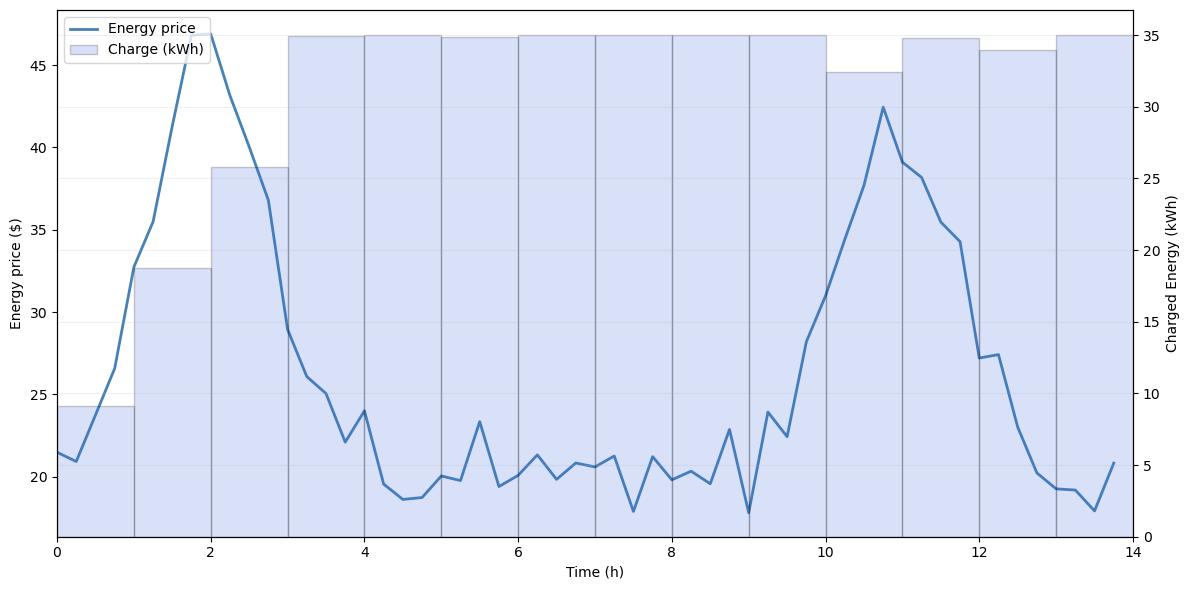

In [41]:
charging_p=df.copy().drop(columns=["Time","TotalPower"])

# Step 1: Make sure your index is float time values
time_index = charging_p.index.astype(float)

# Step 2: Total power across EVs at each timestep
total_power_per_timestep = charging_p.sum(axis=1)

# Step 3: Define hour bins
start = np.floor(time_index.min())
end = np.ceil(time_index.max())
bins = np.arange(start, end + 1, 1.0)

# Step 4: Cut into bins — use integer labels
binned = pd.cut(time_index, bins=bins, labels=bins[:-1].astype(int), right=False)

# Step 5: Group and sum
power_per_hour = total_power_per_timestep.groupby(binned).sum()

# Convert index to float so we can use it in bar plot
x = power_per_hour.index.astype(float)
y = power_per_hour.values

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Line (energy price)
line = ax1.plot(
    dfs["energy_prices"]["time"], 
    dfs["energy_prices"]["price"], 
    color="steelblue", 
    linewidth=2, 
    label="Energy price"
)

# Bar (charging energy)
bars = ax2.bar(
    x=x, 
    height=y, 
    width=1.0, 
    align='edge', 
    color='royalblue', 
    edgecolor='black', 
    alpha=0.2, 
    label="Charge (kWh)"
)

# Axis labels
ax1.set_xlabel("Time (h)")
ax1.set_xlim([0, 14])
ax1.set_ylabel("Energy price ($)")
ax2.set_ylabel("Charged Energy (kWh)")

# Combine legends from both axes
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1],loc="upper left")
plt.grid(True,alpha=0.2)
plt.tight_layout()
plt.show()

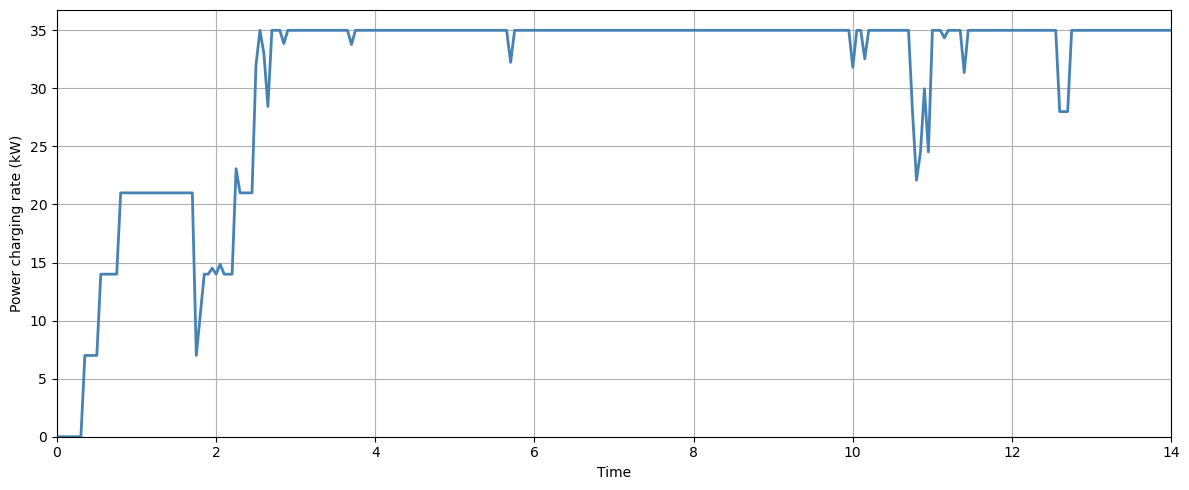

In [38]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["TotalPower"]/step, color="steelblue", linewidth=2)
# plt.title("Total power charged for the EV during the operation window", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Power charging rate (kW)")
plt.xlim([0,14])
plt.ylim(0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
session_df = dfs["arrivals"]

df=df.copy()
df.index=df["Time"]

charged_energy = df.drop(columns=["Time", "TotalPower"]).cumsum()

charging_prof=charged_energy.div(session_df["required_energy"])

charging_prof=charging_prof.T


C:\Users\wilma\AppData\Local\Temp\ipykernel_35484\170710322.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlGn")


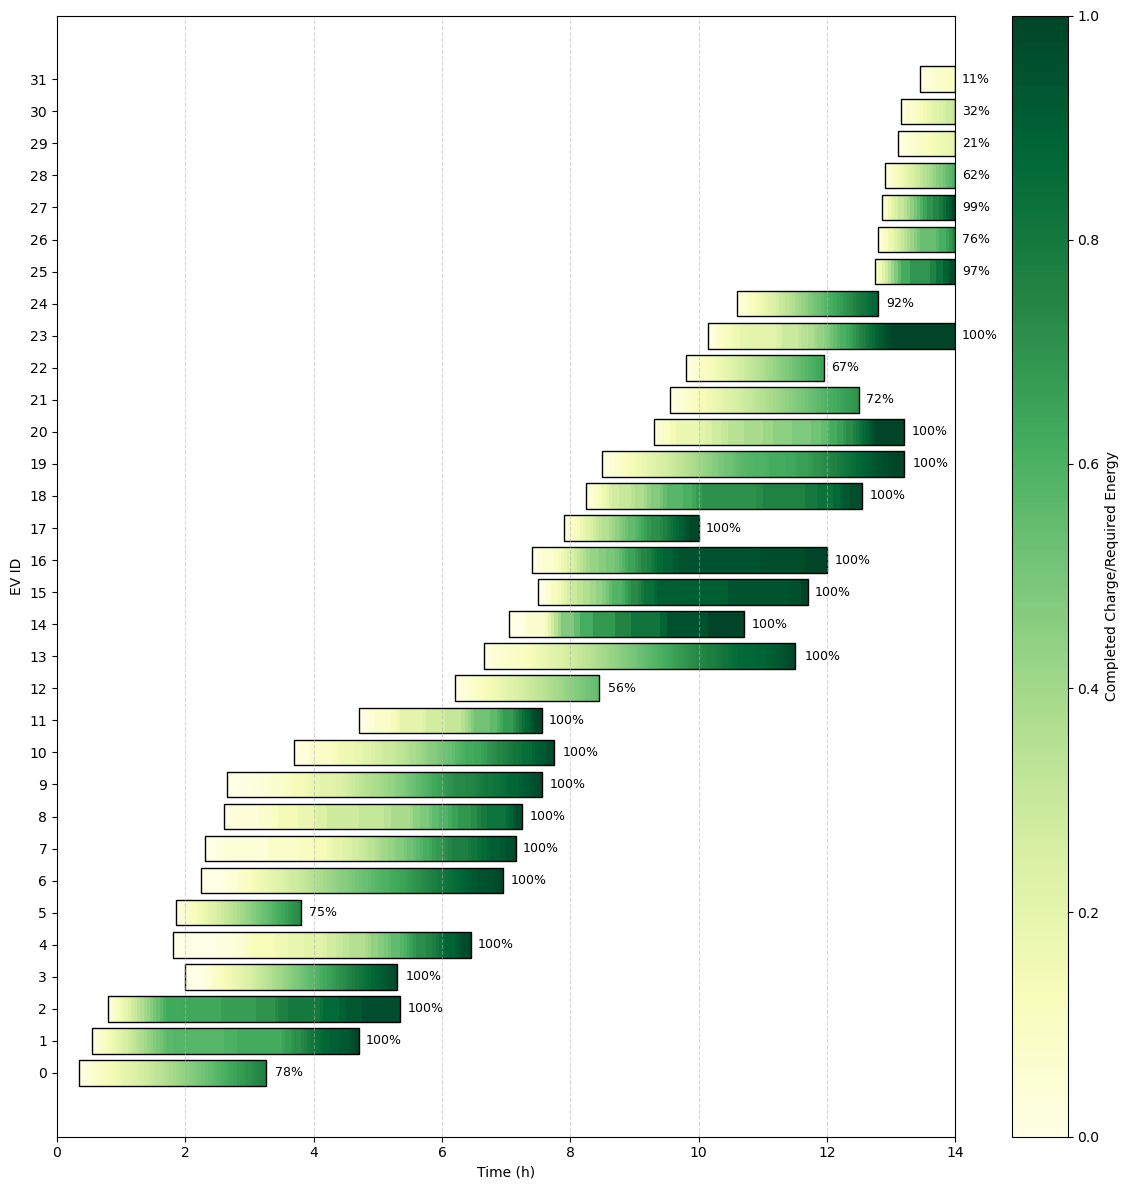

In [40]:
# Plot
fig, ax = plt.subplots(figsize=(12, 12))
cmap = cm.get_cmap("YlGn")
norm = Normalize(vmin=0, vmax=1)

# Time Values
time_values = np.array([float(t) for t in charging_prof.columns])

# Loop through each EV
for i, row in charging_prof.iterrows():
    ev_id = str(i)
    arrival = session_df.loc[i, "arrival_time"]
    departure = session_df.loc[i, "departure_time"]

    # Extract power values as a NumPy array
    powers = row.values

    # Filter time window
    mask = (time_values >= arrival) & (time_values <= departure)
    times = time_values[mask]
    powers = powers[mask]

    # # Normalize power for color (or replace with cumulative energy/efficiency if preferred)
    colors = cmap(norm(powers))

    # Draw segments
    for j in range(len(times) - 1):
        ax.barh(
            y=ev_id,
            width=times[j+1] - times[j],
            left=times[j],
            height=0.8,
            color=colors[j],
            edgecolor="none"
        )
    ax.barh(
        y=ev_id,
        width=times[-1] - times[0],
        left=times[0],
        height=0.8,
        color="none",
        edgecolor="black"
    )
    percent = powers[-1] * 100

    # Add annotation
    ax.text(
        x=departure + 0.1,  # small offset to the right
        y=int(ev_id),
        s=f"{percent:.0f}%",
        va="center",
        ha="left",
        fontsize=9,
        color="black"
    )

ax.set_xlabel("Time (h)")
ax.set_ylabel("EV ID")
# ax.set_title("EV Charging Schedule")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
ax.set_xlim([0,14])
# Step 5: Colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Completed Charge/Required Energy")
plt.tight_layout()
plt.show()